# **The Problem Description:**

**The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities.**


**The aim is to build a predictive model and find out the sales of each product at a particular store (Item_Outlet_Sales[Ycol]).**

**Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.**

# **Importing Libraries**

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Reading Data**

In [3]:
a=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Etlhive/14-05-2022 BigMart Project/Train.csv")

In [4]:
pd.set_option("display.max_columns",2000)

In [5]:
a.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
a.shape

(8523, 12)

In [7]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# **Missing Data Treatment**

In [8]:
a.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
a[["Item_Weight"]].mean()

Item_Weight    12.857645
dtype: float64

In [10]:
a[["Outlet_Size"]].mode()

,Outlet_Size
0,Medium


In [11]:
for i in a.columns:
  if a[i].dtypes=="object":
    x=list(a[i].mode())[0]
    a[i]=a[i].fillna(x)
  else:
    x=a[i].mean()
    a[i]=a[i].fillna(x)

In [12]:
a.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## **Skew Analysis**

In [13]:
a.skew()

Item_Weight                  0.090561
Item_Visibility              1.167091
Item_MRP                     0.127202
Outlet_Establishment_Year   -0.396641
Item_Outlet_Sales            1.177531
dtype: float64

# **Correlation**

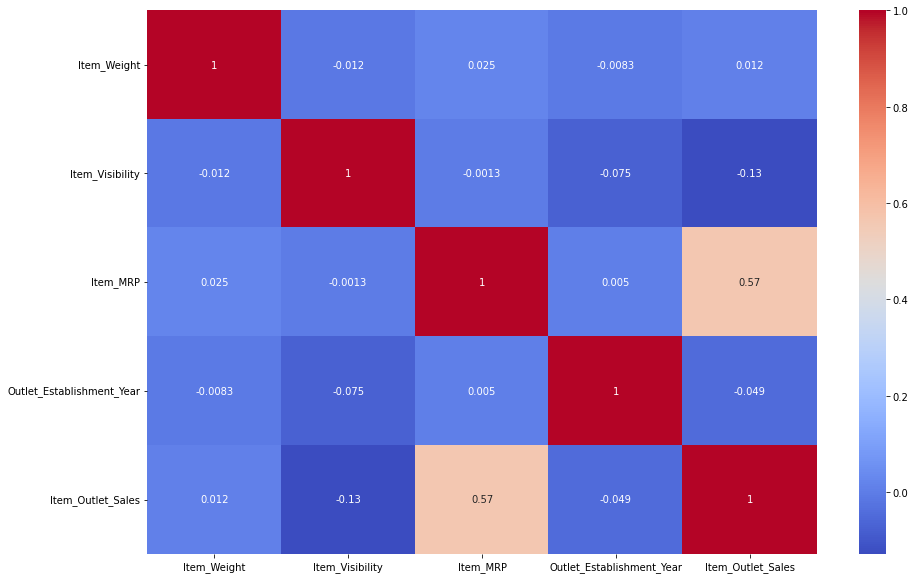

In [14]:
plt.figure(figsize=(15,10))
sb.heatmap(a.corr(),annot=True,cmap="coolwarm");

In [15]:
CORR=a.corr()[["Item_Outlet_Sales"]].sort_values(by="Item_Outlet_Sales")
CORR

,Item_Outlet_Sales
Item_Visibility,-0.128625
Outlet_Establishment_Year,-0.049135
Item_Weight,0.011550
Item_MRP,0.567574
Item_Outlet_Sales,1.000000


In [16]:
con_col_drop=list(CORR[CORR["Item_Outlet_Sales"]<0.5].index)
con_col_drop

['Item_Visibility', 'Outlet_Establishment_Year', 'Item_Weight']

# **ANOVA**

In [17]:
def CATCON(df):
  import pandas as pd
  cat=[]
  con=[]
  for i in df.columns:
    if df[i].dtypes=="object":
      cat.append(i)
    else:
      con.append(i)
  return cat,con

In [18]:
cat,con=CATCON(a)

In [19]:
cat

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [20]:
def ANOVA(df):
  import pandas as pd
  i=0
  Q=pd.DataFrame()
  pvalues=[]
  while i < len(cat):
    from statsmodels.api import OLS
    from statsmodels.formula.api import ols
    reg="Item_Outlet_Sales" + "~" + cat[i]
    model=ols(reg,df).fit()

    from statsmodels.stats.anova import anova_lm
    q=anova_lm(model)
    pvalues.append(round(q.iloc[0,4],6))
    i+=1
  Q["Categorical"]=pd.DataFrame(cat)
  Q["pvalues"]=pd.DataFrame(pvalues)
  cat_col_drop=pd.DataFrame(Q[(Q["pvalues"]>0.04) | (Q["pvalues"].isna())])
  
  print("Categorical Columns to Drop: \n")
  return cat_col_drop

In [21]:
result=ANOVA(a)
result

Categorical Columns to Drop: 



,Categorical,pvalues
1,Item_Fat_Content,0.141221


In [22]:
cat_col_drop=list(result.Categorical)
cat_col_drop

['Item_Fat_Content']

In [23]:
col_related_to_Y=["Item_Outlet_Sales"]

In [24]:
col_of_less_significance=['Item_Identifier']

In [25]:
cols_to_drop=col_related_to_Y + cat_col_drop + con_col_drop + col_of_less_significance

In [26]:
cols_to_drop

['Item_Outlet_Sales',
 'Item_Fat_Content',
 'Item_Visibility',
 'Outlet_Establishment_Year',
 'Item_Weight',
 'Item_Identifier']

# **Defining X and Y**

In [27]:
Y=a[["Item_Outlet_Sales"]]

In [28]:
X=a.drop(labels=cols_to_drop,axis=1)

In [29]:
X.head(3)

,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1
1,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2
2,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1


# **Preprocessing**

In [30]:
def prep(df):
  cat=[]
  con=[]
  import pandas as pd
  for i in df.columns:
    if df[i].dtypes=="object":
      cat.append(i)
    else:
      con.append(i)

  X1=pd.get_dummies(df[cat])

  from sklearn.preprocessing import StandardScaler
  ss=StandardScaler()
  
  X2=pd.DataFrame(ss.fit_transform(df[con]),columns=con)

  Xnew=X2.join(X1)
  return Xnew

In [31]:
Xnew=prep(X)

In [32]:
Xnew.head(2)

,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,1.747454,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0
1,-1.489023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


In [33]:
Xnew.shape

(8523, 37)

# **Train Test Split**

In [34]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

In [35]:
import seaborn as sb
from warnings import filterwarnings
filterwarnings("ignore")

# **Sampling Bias Analysis**

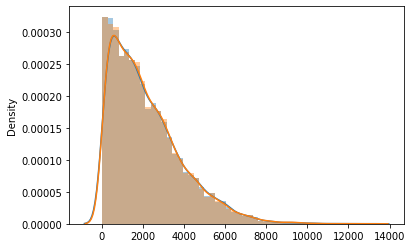

In [36]:
sb.distplot(ytrain)
sb.distplot(Y);

### **We have no sampling bias as both curves almost overlap each other.**

# **Model 1**

In [37]:
from statsmodels.api import OLS,add_constant
xconst=add_constant(xtrain)
ols=OLS(ytrain,xconst)
model = ols.fit()
print("-------------------")
print("Adj_Rsquared",model.rsquared_adj)
print("Rsquared",model.rsquared)
print("-------------------")

-------------------
Adj_Rsquared 0.5626630622518085
Rsquared 0.564266909023659
-------------------


In [38]:
PVAL=list(model.pvalues.sort_values().index)
PVAL

['Item_MRP',
 'Outlet_Type_Supermarket Type3',
 'Outlet_Identifier_OUT018',
 'Item_Type_Seafood',
 'Outlet_Type_Grocery Store',
 'Item_Type_Canned',
 'const',
 'Item_Type_Fruits and Vegetables',
 'Outlet_Identifier_OUT046',
 'Item_Type_Snack Foods',
 'Item_Type_Meat',
 'Item_Type_Health and Hygiene',
 'Outlet_Size_High',
 'Item_Type_Frozen Foods',
 'Item_Type_Breakfast',
 'Outlet_Identifier_OUT013',
 'Item_Type_Breads',
 'Item_Type_Baking Goods',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Identifier_OUT019',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Identifier_OUT049',
 'Item_Type_Household',
 'Outlet_Identifier_OUT017',
 'Item_Type_Dairy',
 'Item_Type_Hard Drinks',
 'Item_Type_Others',
 'Outlet_Identifier_OUT045',
 'Outlet_Size_Medium',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Identifier_OUT010',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Identifier_OUT035',
 'Outlet_Identifier_O

# **Model 2**

In [39]:
col_drop=PVAL[-1]
PVAL.remove(PVAL[-1])
print("Column to drop: ",col_drop)
Xnew=Xnew.drop(labels=col_drop,axis=1)
Y=a[["Item_Outlet_Sales"]]

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from statsmodels.api import OLS,add_constant
xconst=add_constant(xtrain)
ols=OLS(ytrain,xconst)
model = ols.fit()

print("-------------------")
print("Adj_Rsquared",model.rsquared_adj)
print("Rsquared",model.rsquared)
print("-------------------")

Column to drop:  Outlet_Identifier_OUT027
-------------------
Adj_Rsquared 0.5626662964329892
Rsquared 0.5642701313441194
-------------------


#**Model 3**

In [40]:
col_drop=PVAL[-1]
PVAL.remove(PVAL[-1])
print("Column to drop: ",col_drop)
Xnew=Xnew.drop(labels=col_drop,axis=1)
Y=a[["Item_Outlet_Sales"]]

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from statsmodels.api import OLS,add_constant
xconst=add_constant(xtrain)
ols=OLS(ytrain,xconst)
model = ols.fit()

print("-------------------")
print("Adj_Rsquared",model.rsquared_adj)
print("Rsquared",model.rsquared)
print("-------------------")

Column to drop:  Outlet_Identifier_OUT035
-------------------
Adj_Rsquared 0.5626618151186471
Rsquared 0.5642656664641119
-------------------


#**Model 4**

In [41]:
col_drop=PVAL[-1]
PVAL.remove(PVAL[-1])
print("Column to drop: ",col_drop)
Xnew=Xnew.drop(labels=col_drop,axis=1)
Y=a[["Item_Outlet_Sales"]]

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from statsmodels.api import OLS,add_constant
xconst=add_constant(xtrain)
ols=OLS(ytrain,xconst)
model = ols.fit()

print("-------------------")
print("Adj_Rsquared",model.rsquared_adj)
print("Rsquared",model.rsquared)
print("-------------------")

Column to drop:  Outlet_Type_Supermarket Type2
-------------------
Adj_Rsquared 0.5626634127860383
Rsquared 0.5642672582723738
-------------------


#**Model 5**

In [42]:
col_drop=PVAL[-1]
PVAL.remove(PVAL[-1])
print("Column to drop: ",col_drop)
Xnew=Xnew.drop(labels=col_drop,axis=1)
Y=a[["Item_Outlet_Sales"]]

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from statsmodels.api import OLS,add_constant
xconst=add_constant(xtrain)
ols=OLS(ytrain,xconst)
model = ols.fit()

print("-------------------")
print("Adj_Rsquared",round(model.rsquared_adj,4))
print("Rsquared",round(model.rsquared,4))
print("-------------------")

Column to drop:  Outlet_Identifier_OUT010
-------------------
Adj_Rsquared 0.5627
Rsquared 0.5643
-------------------


#**Model 6**

In [43]:
col_drop=PVAL[-1]
PVAL.remove(PVAL[-1])
print("Column to drop: ",col_drop)
Xnew=Xnew.drop(labels=col_drop,axis=1)
Y=a[["Item_Outlet_Sales"]]

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from statsmodels.api import OLS,add_constant
xconst=add_constant(xtrain)
ols=OLS(ytrain,xconst)
model = ols.fit()

print("-------------------")
print("Adj_Rsquared",round(model.rsquared_adj,4))
print("Rsquared",round(model.rsquared,4))
print("-------------------")

Column to drop:  Outlet_Location_Type_Tier 3
-------------------
Adj_Rsquared 0.5626
Rsquared 0.5643
-------------------


#**Model 7**

In [44]:
col_drop=PVAL[-1]
PVAL.remove(PVAL[-1])
print("Column to drop: ",col_drop)
Xnew=Xnew.drop(labels=col_drop,axis=1)
Y=a[["Item_Outlet_Sales"]]

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from statsmodels.api import OLS,add_constant
xconst=add_constant(xtrain)
ols=OLS(ytrain,xconst)
model = ols.fit()

print("-------------------")
print("Adj_Rsquared",round(model.rsquared_adj,4))
print("Rsquared",round(model.rsquared,4))
print("-------------------")

Column to drop:  Outlet_Size_Small
-------------------
Adj_Rsquared 0.5627
Rsquared 0.5643
-------------------


#**Model 8**

In [45]:
col_drop=PVAL[-1]
PVAL.remove(PVAL[-1])
print("Column to drop: ",col_drop)
Xnew=Xnew.drop(labels=col_drop,axis=1)
Y=a[["Item_Outlet_Sales"]]

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from statsmodels.api import OLS,add_constant
xconst=add_constant(xtrain)
ols=OLS(ytrain,xconst)
model = ols.fit()

print("-------------------")
print("Adj_Rsquared",round(model.rsquared_adj,4))
print("Rsquared",round(model.rsquared,4))
print("-------------------")

Column to drop:  Outlet_Type_Supermarket Type1
-------------------
Adj_Rsquared 0.5627
Rsquared 0.5643
-------------------


#**Model 9 (Best Model)**

In [46]:
col_drop=PVAL[-1]
PVAL.remove(PVAL[-1])
print("Column to drop: ",col_drop)
Xnew=Xnew.drop(labels=col_drop,axis=1)
Y=a[["Item_Outlet_Sales"]]

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from statsmodels.api import OLS,add_constant
xconst=add_constant(xtrain)
ols=OLS(ytrain,xconst)
model = ols.fit()

print("-------------------")
print("Adj_Rsquared",round(model.rsquared_adj,4))
print("Rsquared",round(model.rsquared,4))
print("-------------------")

Column to drop:  Outlet_Size_Medium
-------------------
Adj_Rsquared 0.5627
Rsquared 0.5643
-------------------


In [47]:
Xnew.head(3)

,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3
0,1.747454,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,-1.489023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.010040,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [48]:
Xnew.shape

(8523, 29)

In [49]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from sklearn.linear_model import LinearRegression
lm=LinearRegression()
model = lm.fit(xtrain,ytrain)

pred_tsBF=model.predict(xtest)
pred_trBF=model.predict(xtrain)

from sklearn.metrics import mean_squared_error

biasBF=mean_squared_error(ytrain,pred_trBF)
varianceBF=mean_squared_error(ytest,pred_tsBF)
print("______________________________________")
print("Bias: ",biasBF)
print("Variance: ",varianceBF)
print("______________________________________")

______________________________________
Bias:  1273434.7301146588
Variance:  1263390.2825407963
______________________________________


In [50]:
Xnew.columns

Index(['Item_MRP', 'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_High', 'Outlet_Location_Type_Tier 1',
       'Outlet_Location_Type_Tier 2', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [51]:
to_keep=list(Xnew.columns)
to_keep

['Item_MRP',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT019',
 'Outlet_Identifier_OUT045',
 'Outlet_Identifier_OUT046',
 'Outlet_Identifier_OUT049',
 'Outlet_Size_High',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type3']

## **Regularisation Using Ridge Regression**

In [52]:
vals_to_try=[]
x=1
for i in range(0,50):
  x=x-0.001
  vals_to_try.append(round(x,3))

x=1
for i in range(0,50):
  x=x+0.001
  vals_to_try.append(round(x,3))
  

In [53]:
tuning_grid={"alpha":vals_to_try}

In [54]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from sklearn.linear_model import Ridge
rr=Ridge()
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rr,tuning_grid,scoring="neg_mean_squared_error",cv=4)
cvmodel=cv.fit(xtrain,ytrain)
cvmodel.best_params_

{'alpha': 1.05}

In [55]:
rr=Ridge(alpha=1.05)
model=rr.fit(xtrain,ytrain)

pred_ts=model.predict(xtest)
pred_tr=model.predict(xtrain)

from sklearn.metrics import mean_squared_error

bias=mean_squared_error(ytrain,pred_tr)
variance=mean_squared_error(ytest,pred_ts)
print("---------Before Ridge-----------")
print("Bias: ",biasBF,"Variance: ",varianceBF)
print("---------After Ridge-----------")
print("Bias: ",bias,"Variance: ",variance)

---------Before Ridge-----------
Bias:  1273434.7301146588 Variance:  1263390.2825407963
---------After Ridge-----------
Bias:  1273432.5143751304 Variance:  1263356.9332940858


## **Steps performed on TESTING dataset**

1. B=read data
2. replacer
3. skew if any
4. cols_to_drop from B
5. define X
6. Preprocessing
7. Remove columns from Xnew
8. If missing any columns add new columns to Xnew with value equal to 0
9. Predict using alpha = 1.05 Ridge Regression

In [56]:
B=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Etlhive/14-05-2022 BigMart Project/Test.csv")

In [57]:
B.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store


In [58]:
B.skew()

Item_Weight                  0.129975
Item_Visibility              1.238312
Item_MRP                     0.136182
Outlet_Establishment_Year   -0.396306
dtype: float64

In [59]:
B.shape

(5681, 11)

In [60]:
a.shape

(8523, 12)

In [61]:
cols_to_drop

['Item_Outlet_Sales',
 'Item_Fat_Content',
 'Item_Visibility',
 'Outlet_Establishment_Year',
 'Item_Weight',
 'Item_Identifier']

In [62]:
cols_to_drop.remove("Item_Outlet_Sales")

In [63]:
B=B.drop(labels=cols_to_drop,axis=1)

In [64]:
def prep(df):
  cat=[]
  con=[]
  import pandas as pd
  for i in df.columns:
    if df[i].dtypes=="object":
      cat.append(i)
    else:
      con.append(i)

  X1=pd.get_dummies(df[cat])

  from sklearn.preprocessing import StandardScaler
  ss=StandardScaler()
  
  X2=pd.DataFrame(ss.fit_transform(df[con]),columns=con)

  Xnew=X2.join(X1)
  return Xnew

In [65]:
Bnew=prep(B)

In [66]:
Bnew.head(2)

,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,-0.536555,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0
1,-0.868937,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [67]:
Xnew.shape

(8523, 29)

In [68]:
Bnew.shape

(5681, 37)

In [69]:
to_keep

['Item_MRP',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT019',
 'Outlet_Identifier_OUT045',
 'Outlet_Identifier_OUT046',
 'Outlet_Identifier_OUT049',
 'Outlet_Size_High',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type3']

In [70]:
Bnew_cols=list(Bnew.columns)
Bnew_cols

['Item_MRP',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Identifier_OUT010',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT019',
 'Outlet_Identifier_OUT027',
 'Outlet_Identifier_OUT035',
 'Outlet_Identifier_OUT045',
 'Outlet_Identifier_OUT046',
 'Outlet_Identifier_OUT049',
 'Outlet_Size_High',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3']

In [71]:
to_remove=[]
for cols in Bnew_cols:
  if cols not in to_keep:
    to_remove.append(cols)
  else:
    pass

In [72]:
to_remove

['Outlet_Identifier_OUT010',
 'Outlet_Identifier_OUT027',
 'Outlet_Identifier_OUT035',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2']

In [73]:
Bfinal=Bnew.drop(labels=to_remove,axis=1)


In [74]:
Bfinal.head(2)

,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3
0,-0.536555,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,-0.868937,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [75]:
Bfinal.shape

(5681, 29)

In [76]:
Xnew.shape

(8523, 29)

In [77]:
from sklearn.linear_model import Ridge

rr=Ridge(alpha=1.05)
model=rr.fit(Xnew,Y)

predicted=model.predict(Bfinal)

In [78]:
predicted

array([[1836.14574176],
       [1488.83907841],
       [1898.95231691],
       ...,
       [1827.23950984],
       [3556.48531933],
       [1268.07326667]])

In [79]:
B.head(2)

,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1
1,Dairy,87.3198,OUT017,NaN,Tier 2,Supermarket Type1


In [80]:
T=B[["Item_Type","Item_MRP","Outlet_Identifier","Outlet_Size","Outlet_Location_Type","Outlet_Type"]]

In [81]:
T["Pred_ItemOutlet_Sales"]=predicted

In [82]:
#T.to_csv("Pred_ItemOutlet_Sales.csv")

In [83]:
#T.to_excel("Pred_ItemOutlet_Sales.xlsx")

In [84]:
T

,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Pred_ItemOutlet_Sales
0,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,1836.145742
1,Dairy,87.3198,OUT017,NaN,Tier 2,Supermarket Type1,1488.839078
2,Others,241.7538,OUT010,NaN,Tier 3,Grocery Store,1898.952317
3,Snack Foods,155.0340,OUT017,NaN,Tier 2,Supermarket Type1,2583.241071
4,Dairy,234.2300,OUT027,Medium,Tier 3,Supermarket Type3,5136.512093
...,...,...,...,...,...,...,...
5676,Snack Foods,141.3154,OUT046,Small,Tier 1,Supermarket Type1,2264.375122
5677,Starchy Foods,169.1448,OUT018,Medium,Tier 3,Supermarket Type2,2455.332775
5678,Health and Hygiene,118.7440,OUT045,NaN,Tier 2,Supermarket Type1,1827.239510
5679,Canned,214.6218,OUT017,NaN,Tier 2,Supermarket Type1,3556.485319


# **END**